<a href="https://colab.research.google.com/github/witkov/chi-squared/blob/master/chisq_expert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Number of data points: 3
Best-fit slope: 1.069 ± 0.035
Best-fit intercept: 1.109 ± 0.066
Min_chi2: 0.655
Good fit min_chi2 range: 0.551 to 5.449




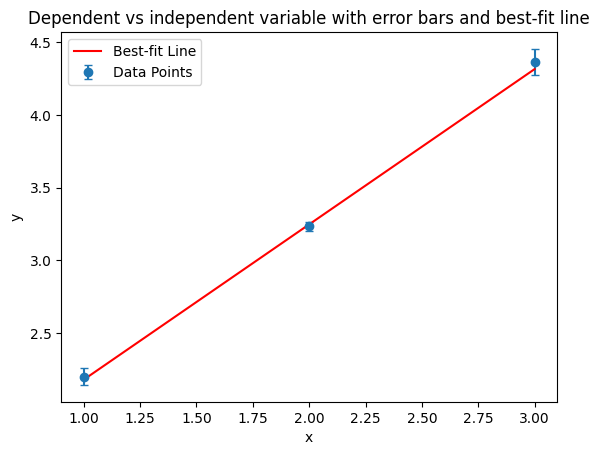

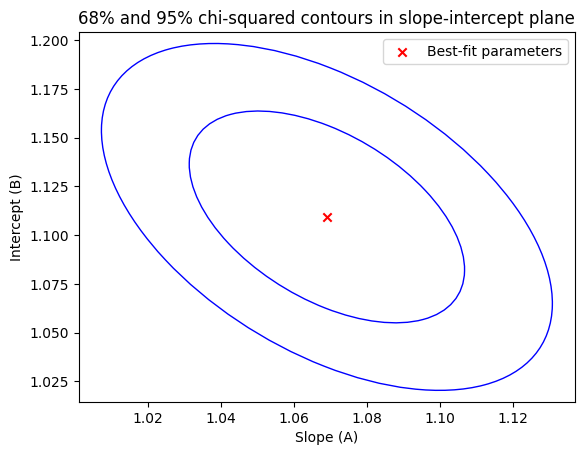

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize_scalar

# *** EDIT DATA AND MODEL ***

x_mean = np.array([1, 2, 3]) # Enter distinct (non-repeating) values of independent variable.
y_mean =np.array([2.200, 3.233, 4.367]) # Enter means of dependent variable measurements.
n = np.array([3, 3, 3]) # Enter number of measurements at each distinct value of independent variable.
sigma_y = np.array([0.1, 0.0577, 0.153])/np.sqrt(n) # Enter (sample) standard deviations. This line converts std dev to std error.

x = x_mean # Enter functional relationship between model and measured values of independent variable.
y = y_mean # Enter functional relationship between model and measured values of dependent variable.
yerr = sigma_y # Enter model uncertainty in terms of measurement uncertainty using error propagation.

# Below is another example: 
# x = log(x_mean)
# y = log(y_mean)
# yerr = sigma_y/y

# *** DO NOT EDIT BELOW THIS LINE *** 

def mean(arr):
    return np.mean(arr)

def plot_chi_squared_ellipses(A_best, B_best, var_A, var_B, cov_AB):
    fig, ax = plt.subplots()
    ax.scatter(A_best, B_best, color='red', marker='x', label='Best-fit parameters')

    # Define the chi-squared contours at delta_chi2 = 2.3 and delta_chi2 = 6.17
    delta_chi2 = [2.3, 6.17]

    for chi2 in delta_chi2:
        # Calculate the semi-major and semi-minor axes and rotation angle for the ellipse
        a = np.sqrt(2.0 * chi2 * var_A)
        b = np.sqrt(2.0 * chi2 * var_B)
        theta = 0.5 * np.arctan(2.0 * cov_AB / (var_A - var_B))
        theta = np.degrees(theta)

        # Create the ellipse
        ellipse = Ellipse(xy=(A_best, B_best), width=a * 2, height=b * 2, angle=theta, edgecolor='blue', fill=False)
        ax.add_patch(ellipse)

    ax.set_xlabel('Slope (A)')
    ax.set_ylabel('Intercept (B)')
    ax.legend(loc='best')
    plt.title('68% and 95% chi-squared contours in slope-intercept plane')
    plt.show()

# calculate sums needed to calculate chi-squared in closed-form
s_yy = sum(y ** 2 / yerr ** 2)
s_xx = sum(x ** 2 / yerr ** 2)
s_0 = sum(1 / yerr ** 2)
s_xy = sum((y * x) / yerr ** 2)
s_y = sum(y / yerr ** 2)
s_x = sum(x / yerr ** 2)

# Calculate the best-fit slope and intercept
A_best = (s_0 * s_xy - s_x * s_y) / (s_0 * s_xx - s_x ** 2)
B_best = (s_y * s_xx - s_x * s_xy) / (s_0 * s_xx - s_x ** 2)

# Calculate the variance and covariance
var_A = 1 / s_xx
var_B = 1 / s_0
cov_AB = -s_x / (s_xx * s_0)

# Calculate the chi-squared min value
min_chi2 = s_yy + (s_0 * s_xy ** 2 - 2 * s_x * s_y * s_xy + s_y ** 2 * s_xx) / (s_x ** 2 - s_0 * s_xx)

# Define the chi-squared function in terms of slope
def chi_squared(slope):
    intercept = (s_y - s_x * slope) / s_0
    return s_yy + s_xx * slope ** 2 + s_0 * intercept ** 2 - 2 * (s_x * s_y * slope + s_x * intercept * slope - s_y * intercept)

# Find the slope values that correspond to chi_squared_min + 1
target_chi_squared = min_chi2 + 1
result_1 = minimize_scalar(lambda slope: (chi_squared(slope) - target_chi_squared) ** 2, bounds=(A_best - 5 * np.sqrt(var_A), A_best))
result_2 = minimize_scalar(lambda slope: (chi_squared(slope) - target_chi_squared) ** 2, bounds=(A_best, A_best + 5 * np.sqrt(var_A)))

# Calculate the uncertainties in the slope and intercept
slope_uncertainty = np.abs(result_1.x - result_2.x) / 2
intercept_uncertainty = np.abs((s_y - s_x * result_1.x) / s_0 - (s_y - s_x * result_2.x) / s_0) / 2

# Display the results
print("\n")
print("Number of data points:", len(x))
print(f"Best-fit slope: {A_best:.3f} ± {slope_uncertainty:.3f}")
print(f"Best-fit intercept: {B_best:.3f} ± {intercept_uncertainty:.3f}")
print(f"Min_chi2: {min_chi2:.3f}")
#print(f"s_0: {s_0:.3f}")
#print(f"s_x: {s_x:.3f}")
#print(f"s_xx: {s_xx:.3f}")
#print(f"s_y: {s_y:.3f}")
#print(f"s_xy: {s_xy:.3f}")
#print(f"s_yy: {s_yy:.3f}")

# Calculate the good fit range
N = len(x)  # Number of distinct x values
lower_bound = N - np.sqrt(2*N)
upper_bound = N + np.sqrt(2*N)
good_fit_range = f"{lower_bound:.3f} to {upper_bound:.3f}"

print(f"Good fit min_chi2 range: {good_fit_range}")
print("\n")

# Generate scatter plot with vertical error bars and best-fit line
plt.errorbar(x, y, yerr=yerr, fmt='o', label='Data Points', capsize=3)
plt.plot(x, A_best * x + B_best, label='Best-fit Line', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Dependent vs independent variable with error bars and best-fit line')
plt.show()

# Plot the chi-squared ellipses
plot_chi_squared_ellipses(A_best, B_best, var_A, var_B, cov_AB)
